<center><b>Machine Learning

Master in Computational Finance (MCF)

– Final Project: Clustering through HCA (Hierarchical clustering analysis) method on replication of results from the paper Jaroonchokanan et al. (2022)_Dynamics of Hierarchical Clustering in Stock Market During Financial Crises – 

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf

import sklearn as sk
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# plotting 
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import dcor
import pylab

# 1 Data fetching and preprocessing

Comment:  
*Data for the stock SCB (Siam Commercial Bank) was not available for the full time slot.*

In [48]:
tickers = ['BBL.BK',
'KBANK.BK',
# 'SCB.BK',     # data prior to 2022-04-20 are NOT AVAILABLE anywhere on the internet
'KTB.BK',
'TCAP.BK',
'TISCO.BK',
'TTB.BK', # old ticker was TMB.BK
'KKP.BK',
'KTC.BK',
'ADVANC.BK',
'DTAC.BK',
'INTUCH.BK',
'TRUE.BK',
'JAS.BK',
'EGCO.BK',
'IRPC.BK',
'PTT.BK',
'PTTEP.BK',
'RATCH.BK',
'TOP.BK',
'BANPU.BK',
'BJC.BK',
'CPALL.BK',
'HMPRO.BK',
'CPN.BK',
'LH.BK',
'SPALI.BK',
'AOT.BK',
'BEM.BK',
'BTS.BK',
'CPF.BK',
'MINT.BK',
'TU.BK',
'BDMS.BK',
'BCH.BK',
'BH.BK',
'SCC.BK']

In [49]:
df_stock_prices = yf.download(tickers,group_by='ticker')

[*********************100%***********************]  36 of 36 completed


Stock prices for Siam Commercial Bank are not available prior to 20th Apr 2022, so we will eliminate that ticker from the analysis.

In [50]:
yf.download(["SCB.BK"])

[*********************100%***********************]  1 of 1 completed


Open    High    Low  Close   Adj Close    Volume
Date                                                         
2022-04-20   68.0   87.75   66.0   81.5   80.318840   2840200
2022-04-27  120.0  121.50  113.0  114.0  112.347824  38312500
2022-04-28  112.5  113.50  111.5  112.5  110.869568  39894700
2022-04-29  113.5  115.00  113.0  115.0  113.333336  21106900
2022-05-03  115.0  118.50  113.5  117.5  115.797104  26009800
...           ...     ...    ...    ...         ...       ...
2022-12-26  105.0  105.50  104.5  104.5  104.500000   3487400
2022-12-27  105.0  106.00  105.0  105.5  105.500000   5380600
2022-12-28  105.5  106.00  105.5  106.0  106.000000   4881900
2022-12-29  105.5  106.50  105.5  106.5  106.500000   8023000
2022-12-30  106.5  107.50  106.5  107.0  107.000000   9457000

[166 rows x 6 columns]

In [51]:
prices = (df_stock_prices 
.loc[(df_stock_prices.index > pd.Timestamp(day=2, month=1, year=2008))
    &(df_stock_prices.index < pd.Timestamp(day=19, month=10, year=2020))] # authors used data from from 02/01/2008 to 19/10/2020
.loc[:,(slice(None), 'Close')]  # choose only close prices
.droplevel(level=1, axis=1)     # drop "Close" level of multilevel indexing
.rename(mapper= lambda name: name[:-3], axis=1) # rename tickers by removing ".BK"
)

prices

CPALL    SCC         TU        BJC    AOT   EGCO      SPALI   TOP  \
Date                                                                            
2008-01-03   5.25  224.0   5.140833   6.138554   5.65  108.0   3.600000  83.5   
2008-01-04   5.35  224.0   5.164201   6.138554   5.55  106.0   3.560000  81.5   
2008-01-07   5.15  224.0   5.070731   5.996741   5.55  104.0   3.540000  79.5   
2008-01-08   5.10  226.0   4.930527   5.996741   5.60  105.0   3.480000  82.0   
2008-01-09   5.15  226.0   4.907159   5.996741   5.65  106.0   3.440000  83.0   
...           ...    ...        ...        ...    ...    ...        ...   ...   
2020-10-09  60.50  351.0  15.700000  35.000000  57.50  193.0  16.299999  35.5   
2020-10-12  60.00  350.0  15.600000  35.000000  57.50  190.5  16.200001  36.5   
2020-10-14  60.25  348.0  15.700000  34.750000  57.25  185.5  16.299999  36.0   
2020-10-15  59.25  341.0  15.200000  33.250000  55.75  180.5  16.000000  36.0   
2020-10-16  58.50  334.0  15.600000  32.500000  56.00  180.5  15.900000  35.5   

                HMPRO        LH  ...  INTUCH       MINT    CPF       PTTEP  \
Date                             ...                                         
2008-01-03   0.743143  6.083333  ...   25.25  14.462809   4.50  154.970764   
2008-01-04   0.740123  6.083333  ...   25.50  13.884297   4.42  151.072128   
2008-01-07   0.740123  5.916666  ...   25.25  13.966942   4.44  148.148148   
2008-01-08   0.734081  5.916666  ...   25.25  14.049586   4.40  148.148148   
2008-01-09   0.734081  6.041666  ...   25.25  14.462809   4.42  154.970764   
...               ...       ...  ...     ...        ...    ...         ...   
2020-10-09  15.200000  7.000000  ...   52.50  19.900000  27.50   83.500000   
2020-10-12  15.100000  7.000000  ...   52.75  20.100000  27.00   82.250000   
2020-10-14  14.800000  7.000000  ...   52.50  19.500000  26.50   80.750000   
2020-10-15  14.200000  6.800000  ...   52.25  18.700001  26.00   80.500000   
2020-10-16  14.000000  6.750000  ...   52.25  18.299999  26.25   80.250000   

            ADVANC   JAS     BH   TCAP     KTC      TRUE  
Date                                                      
2008-01-03    95.5  0.40  40.25  14.00   2.975  3.386841  
2008-01-04    97.0  0.39  39.75  13.90   2.950  3.327423  
2008-01-07    95.5  0.38  40.00  13.90   2.950  3.297713  
2008-01-08    98.0  0.38  40.00  13.90   2.950  3.357132  
2008-01-09    97.5  0.37  40.00  14.00   2.950  3.475968  
...            ...   ...    ...    ...     ...       ...  
2020-10-09   177.0  2.82  97.00  29.00  37.750  3.020000  
2020-10-12   178.5  2.80  96.00  28.75  37.750  3.020000  
2020-10-14   176.0  2.80  95.50  28.75  37.750  3.000000  
2020-10-15   175.5  2.78  95.25  28.50  37.500  2.960000  
2020-10-16   173.5  2.70  94.00  28.75  38.000  2.980000  

[3128 rows x 36 columns]

**There is a gap in data** in May of 2017, which we will illustrate on the following plot. This gap will be assessed by `.dropna()` when needed. 

<AxesSubplot:xlabel='Date'>

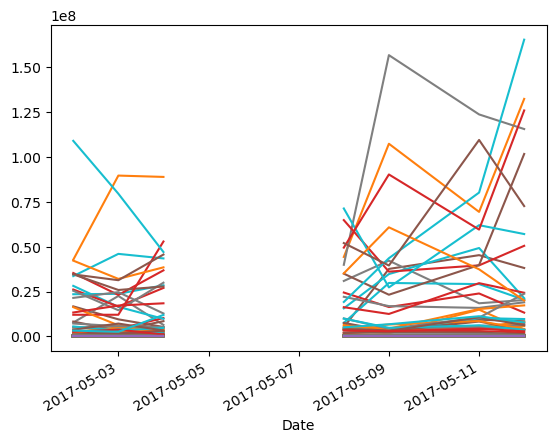

In [52]:
df_stock_prices.loc[(df_stock_prices.index > pd.Timestamp(day=1, month=5, year=2017))
    &(df_stock_prices.index < pd.Timestamp(day=15, month=5, year=2017))].plot(legend=None)

In [53]:
log_prices = prices.applymap(np.log) # compute log prices

log_ret1 = log_prices.diff(periods=1) 
log_ret30 = log_prices.diff(periods=30) 
log_ret120 = log_prices.diff(periods=120) 

In [54]:
scaler = StandardScaler()

scaler_1 = scaler.fit(log_ret1)  # save it for later use
std_ret1 = scaler_1.transform(log_ret1)
std_ret1 = pd.DataFrame(std_ret1, index=log_ret1.index, columns=log_ret1.columns)

scaler_30 = scaler.fit(log_ret30)  # save it for later use
std_ret30 = scaler_30.transform(log_ret30)
std_ret30 = pd.DataFrame(std_ret30, index=log_ret30.index, columns=log_ret30.columns)

scaler_120 = scaler.fit(log_ret120)  # save it for later use
std_ret120 = scaler_120.transform(log_ret120)
std_ret120 = pd.DataFrame(std_ret120, index=log_ret120.index, columns=log_ret120.columns)

# 2 EDA

To make quickly check if we have many outliers or holes in data we wil plot daily log returns and their distributions, for each of the 26 stocks (reminder: one stock is left out because data is not available online). 

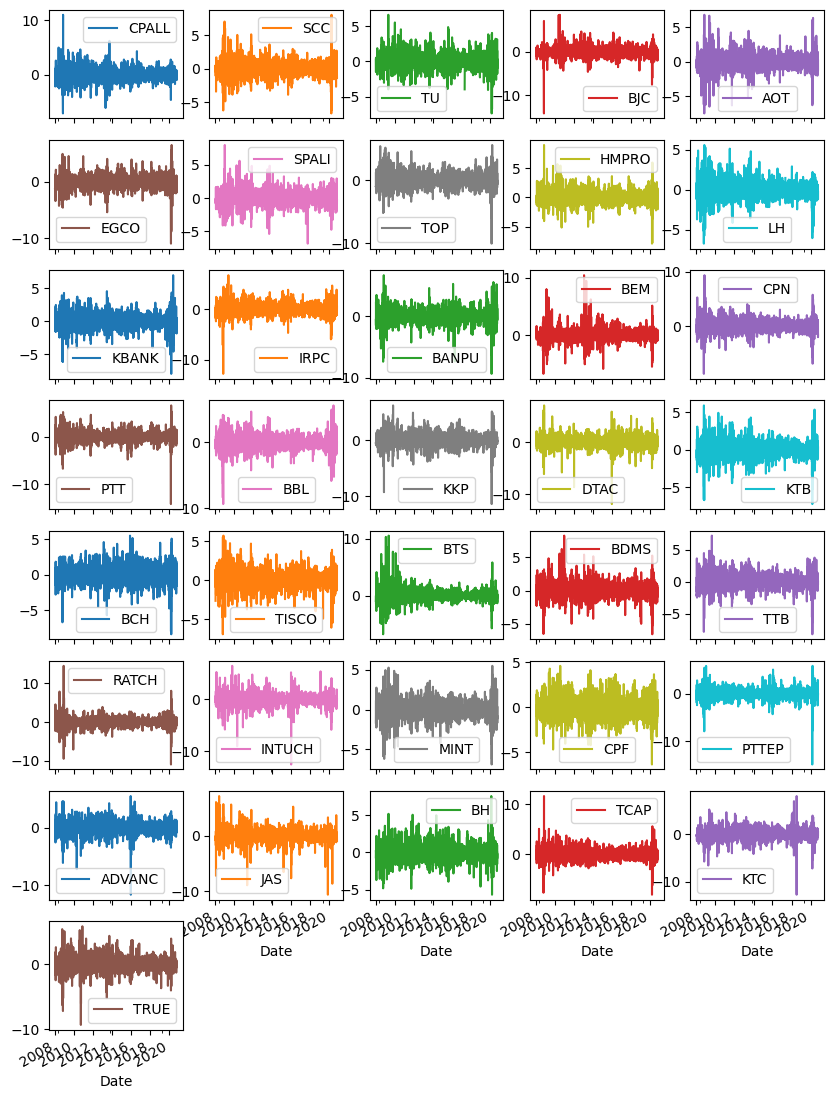

In [69]:
std_ret1.plot(subplots=True, layout=(8, 5), figsize=(10, 15));

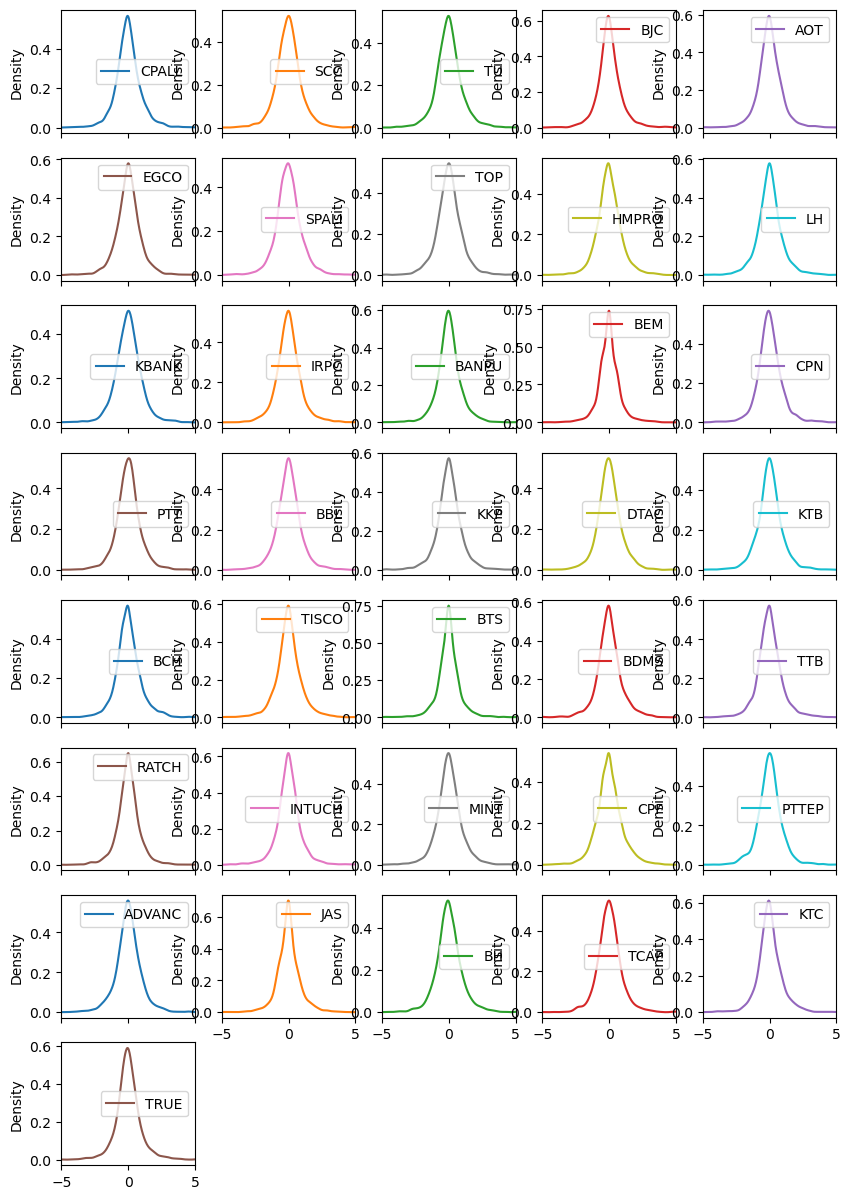

In [70]:
std_ret1.plot(subplots=True, layout=(8, 5), figsize=(10, 15), kind='kde', xlim=(-5,5));

Next two plots are reconstruction of plots from Figure 4 of the paper.

In [57]:
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("Delta t=1","Delta t=30", "Delta t=120"))
fig.add_trace(go.Scatter(x=log_ret1.mean(),y=log_ret1.std(),mode='markers+text' ,text=list(log_ret1.columns),textposition="bottom center",name='One Day'),row=1, col=1)
fig.add_trace(go.Scatter(x=log_ret30.mean(),y=log_ret30.std(),mode='markers+text' ,text=list(log_ret30.columns),textposition="bottom center",name='30 Days'),row=1, col=2)
fig.add_trace(go.Scatter(x=log_ret120.mean(),y=log_ret120.std(),mode='markers+text' ,text=list(log_ret120.columns),textposition="bottom center",name='120 Days'),row=1, col=3)


In [58]:
fig = go.Figure()

# KTB has CV ~ -6000, so we will eliminate it from this plot

fig.add_trace(go.Scatter(
    x=log_ret1.drop("KTB", axis=1).columns,   
    y=(log_ret1.std()/log_ret1.mean()).drop("KTB").values,  
    mode='markers',
    name='One Day CV'))

fig.add_trace(go.Scatter(
    x=log_ret30.drop("KTB", axis=1).columns,
    y=(log_ret30.std()/log_ret30.mean()).drop("KTB").values,
    mode='markers',
    name='30 Days CV'))
fig.add_trace(go.Scatter(
    x=log_ret120.drop("KTB", axis=1).columns,
    y=(log_ret120.std()/log_ret120.mean()).drop("KTB").values,
    mode='markers',
    name='120 Days CV'))
    
fig.update_layout(autosize=False, height=600, width=1200,
    yaxis_title="CV",)

Comment:  
*Typically, stocks with low average return (e.g., TBM, TOP) have high CV in absolute values. The reason being that the denominator is rather small number. On top of it, financial crisis are periods in which there is an increase in volatility. It turns out that the stocks from the energy sector, which are more expensive, tended to fluctuate less than less expensive stocks.*

In the next step we examine autocorrelation plots. Our results match the original results. We note that 3000 lags in ACF are not very informative. 

TODO: compute CDF on log-log scale.

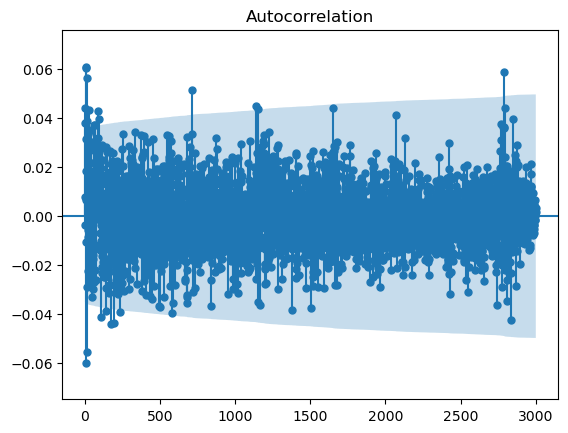

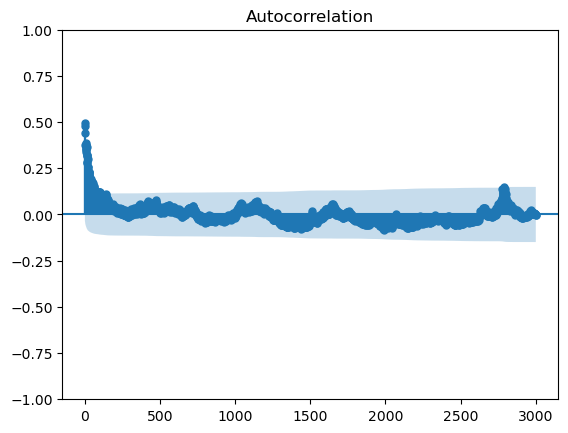

In [59]:
#Average autocorrelation
plot_acf(x=std_ret1.mean(axis=1).dropna(), lags=3000, zero=False, auto_ylims=True)
#Average autocorrelation absolute log returns
plot_acf(x=abs(std_ret1).mean(axis=1).dropna(), lags=3000, zero=False)

plt.show()

Comment:  
*When we plot average autocorrelation of returns and average absolute autocorrelation of absolute returns it shows that none of the lags are statistically signifficant, which is not uncommon, when it comes to the portfolio of returns.*

# 3 Evolution of average entropy, correlation and Fisher information distance

## 3.1 Evolution of Entropy

In [60]:
entropy_evolution = 0.5 * np.log(2 * np.pi * std_ret1.rolling(120).var().dropna()) + 0.5

import plotly.express as px
fig = px.imshow(entropy_evolution, title="Entropy evolution of 36 stocks")
fig.show()

Comment:  
*What we immediately notice is high entoropy in the 2009 and 2020 periods, which are the periods of economic crisis i.e., subprime crisis in 2009 and COVID19 pandemic in 2020.  
Taking into account the whole picture, energy stocks e.g., ERGO and PTT showed lower entropy than the other companies. One possible cause for the lower entropy being that the energy sector stocks were less influenced by crisis due to the Efficiency Development Plan. In the political context we see yellow color in 2013 which coincides with the political crisis in Thailand, and similarly in 2016 there were licence auctions for 4G spectrum, which increased the entropy in telecomunicaton sector (see ADVANC and DTAC in 2016)*

## 3.2 Ulcer index

In [61]:
def calc_ulcer_index(df, periods=14):
    # Returns a dataframe read from filepath with ulcer index as an added column
    # Ulcer Index formula:
    # 1) Percentage Drawdown = [(Close - N-period High Close)/N-period High Close] x 100
    # 2) Squared Average = (N-period Sum of Percent-Drawdown Squared)/N
    # 3) Ulcer Index = Square Root of Squared Average
    #security = get_date_indexed_pd(filepath)
    period_high_close = df.rolling(periods + 1).apply(lambda x: np.amax(x), raw=True)
    percentage_drawdown = df
    percentage_drawdown = (percentage_drawdown - period_high_close)/period_high_close * 100
    percentage_drawdown = np.clip(percentage_drawdown, a_min=None, a_max=0)
    percentage_drawdown = percentage_drawdown ** 2
    percentage_drawdown = percentage_drawdown.fillna(0)
    period_sum = percentage_drawdown.rolling(periods+1).sum()
    squared_average = round((period_sum / periods), 2)
    ulcer_index = round(squared_average ** 0.5, 2)
    #security[column_name] = ulcer_index
    return ulcer_index


In [62]:
fig = make_subplots(rows=1, cols=3)

ulcer_30 = calc_ulcer_index(prices, periods=30).mean(axis=1)
ulcer_120 = calc_ulcer_index(prices, periods=120).mean(axis=1)
ulcer_240 = calc_ulcer_index(prices, periods=240).mean(axis=1)

fig.add_trace(go.Scatter(y=ulcer_30,
                         x=ulcer_30.index,
                         name='Ulcer Index 30 days'),
                         row=1,
                         col=1)

fig.add_trace(go.Scatter(y=ulcer_30,
                         x=ulcer_30.index,
                         name='Ulcer Index 120 days'),
                         row=1,
                         col=2)

fig.add_trace(go.Scatter(y=ulcer_30,
                         x=ulcer_30.index,
                         name='Ulcer Index 240 days'),
                         row=1,
                         col=3)

fig.update_layout(title="ULCER INDEX")

Comment:  
*The Ulcer Index (UI)is a stock market risk measure or technical analysis indicator that measures downside risk in terms of both the depth and duration of price declines.  
The index increases in value as the price moves farther away from a recent high and falls as the price rises to new highs, meaning the greater the value of the Ulcer Index, the longer it takes for stock to get back to the former high. Simply stated, it is designed as one measure of volatility only on the downside.  
Consequently, we observe 4 peaks which typically correspond to the 4 crisis: 2009 subprime crisis, 2014 political crisis, 2016 4G auction and 2020 COVID crisis.*

## 3.3 UI and other measures: replicating Figure 7 from the paper

**DO NOT RUN CODE from this subsection because it runs a bit long and graphs will be computed with one tenth of the time resolution**

In [247]:
# This was an attempt to speed up something. Failed. I left this code in case I need it later.

# from itertools import combinations

# def fisher_distance(X, Y):
#     """ Function which calculates Fisher Information distance
#     Inputs are standardized log returns of two stock"""
#     mux  = X.mean()
#     stdx = X.std()
#     muy  = Y.mean()
#     stdy = Y.std()
#     F = np.sqrt(((mux-muy)**2+2*(stdx-stdy)**2)*((mux-muy)**2+2*(stdx+stdy)**2))
#     D = np.sqrt(2)*np.log((F+(mux-muy)**2+2*(stdx**2+stdy**2))/(4*(stdx*stdy)))
#     return D

# def make_fid_matrix(window):
#     """Computes matrix of FIDs. This function is to be applied to a rolling
#     windows of std_ret to compute FIDs for every timestamp"""
#     #cols = window.columns
#     #idx = cols.copy()
#     mat = window.to_numpy(dtype=float, na_value=np.nan, copy=False).T

#     #K = len(cols)
#     K=36
#     correl = np.empty((K, K), dtype=float)

#     for i, ac in enumerate(mat):
#         for j, bc in enumerate(mat):
#             if i > j:
#                 continue

#             if i == j:
#                 c = 0.0
#             else:
#                 c = fisher_distance(ac, bc)
#             correl[i, j] = c
#             correl[j, i] = c

#     #return pd.DataFrame(correl, index=idx, columns=cols)
#     return correl.sum()/36

# std_ret1.rolling(30).aggregate(make_fid_matrix)

In [250]:
def fisher_clusters1(X,Y):
    """ Function which calculates Fisher Information distance
    Inputs are returns of two stock returns X and Y"""
    mux  = X.mean()
    stdx = X.std()
    muy  = Y.mean()
    stdy = Y.std()
    F = np.sqrt(((mux-muy)**2+2*(stdx-stdy)**2)*((mux-muy)**2+2*(stdx+stdy)**2))
    D = np.sqrt(2)*np.log((F+(mux-muy)**2+2*(stdx**2+stdy**2))/(4*(stdx*stdy)))
    return D

In [262]:
fis_30=[]
for i in range(0, std_ret1.shape[0]-30, 10):
    df = std_ret1.iloc[i:i+30,:]
    # Create the distance method using distance_correlation
    rslt = df.apply(lambda col1: df.apply(lambda col2: fisher_clusters1(col1, col2)))
    rez = np.array(rslt)
    rez[np.diag_indices_from(np.array(rslt))] = np.nan
    fis_30.append(pd.DataFrame(rez).mean().mean())

In [258]:
fis_120=[]
for i in range(0, std_ret1.shape[0]-120, 10):
    df=std_ret1.iloc[i:i+120,:]
    # Create the distance method using distance_correlation
    rslt = df.apply(lambda col1: df.apply(lambda col2: fisher_clusters1(col1, col2)))
    rez=np.array(rslt)
    rez[np.diag_indices_from(np.array(rslt))]=np.nan
    fis_120.append(pd.DataFrame(rez).mean().mean())

In [259]:
fis_240=[]
for i in range(0, std_ret1.shape[0]-240, 10):
    df=std_ret1.iloc[i:i+240,:]
    # Create the distance method using distance_correlation
    rslt = df.apply(lambda col1: df.apply(lambda col2: fisher_clusters1(col1, col2)))
    rez=np.array(rslt)
    rez[np.diag_indices_from(np.array(rslt))]=np.nan
    fis_240.append(pd.DataFrame(rez).mean().mean())

In [263]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(y=fis_30,x=prices.iloc[:-30].index,name='Fisher Information Distance Coefficient 30'),row=1,col=1)
fig.add_trace(go.Scatter(y=fis_120,x=prices.iloc[:-120].index,name='Fisher Information Distance Coefficient 120'),row=1,col=2)
fig.add_trace(go.Scatter(y=fis_240,x=prices.iloc[:-240].index,name='Fisher Information Distance Coefficient 240'),row=1,col=3)
fig.update_layout(title="Fisher Information Distance")

Comment:  
*By comparing the FID (Fisher Information Distance) with the daily average returns of 37 stocks, we saw that the maximum average FID in time windows of 30 and 120 trading days occurred prior to the peak of the correlation distance.
However, the FID peak and the return drop occurred on the same date, March 12, 2020, during Thailand’s emergency lockdown due to the COVID-19 pandemic, which caused the SET Index (Thai composite stock market index) to plummet dramatically as a result.  
This suggests that the average FID can detect larger changes in the returns distribution sooner than the other indicators, and as such could be utilized as a more effective indicator for tracking changes in the stock market. According to the authors of this work this is due to the fact that the FID is calculated using the derivative of their statistical moments such as the mean and variance, whereas the correlation distance is defined as the direct integration of two random variables. While the latter has a smoothing effect, the former is plausibly more sensitive to the changes in market parameters that manifest in the change in the time series returns.*

In [ ]:
def dist_corr(X, Y, pval=True, nruns=2000):
    dc = dcor.distance_correlation(X, Y)
    pv = dcor.independence.distance_covariance_test(X, Y, exponent=1.0, num_resamples=nruns)[0]
    if pval:
        return (dc, pv)
    else:
        return dc

In [264]:
koreli_30=[]
for i in range(0, std_ret1.shape[0]-30, 10):
    df=std_ret1.iloc[i:i+30,:]
    # Create the distance method using distance_correlation
    rslt = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
    rez=np.array(rslt)
    rez[np.diag_indices_from(np.array(rslt))]=np.nan
    koreli_30.append(pd.DataFrame(rez).mean().mean())

In [265]:
koreli_120=[]
for i in range(0, std_ret1.shape[0]-120, 10):
    df=std_ret1.iloc[i:i+120,:]
    # Create the distance method using distance_correlation
    rslt = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
    rez=np.array(rslt)
    rez[np.diag_indices_from(np.array(rslt))]=np.nan
    koreli_120.append(pd.DataFrame(rez).mean().mean())

In [266]:
koreli_240=[]
for i in range(0, std_ret1.shape[0]-240, 10):
    df=std_ret1.iloc[i:i+240,:]
    # Create the distance method using distance_correlation
    rslt = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
    rez=np.array(rslt)
    rez[np.diag_indices_from(np.array(rslt))]=np.nan
    koreli_240.append(pd.DataFrame(rez).mean().mean())

In [ ]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(y=koreli_30,x=prices.iloc[:-30].index,name='Distance correlation 30'),row=1,col=1)
fig.add_trace(go.Scatter(y=koreli_120,x=prices.iloc[:-120].index,name='Distance correlation 120'),row=1,col=2)
fig.add_trace(go.Scatter(y=koreli_240,x=prices.iloc[:-240].index,name='Distance correlation 240'),row=1,col=3)
fig.update_layout(title="Correlation distance")

In [ ]:
def entropy(X):
    var_x=X.var()
    return 0.5*np.log(2*np.pi*var_x)+0.5
    

In [ ]:
entropy_30=[]
for i in range(std_ret1.shape[0]-30):
    df=std_ret1.iloc[i:i+30,:]
    entropy_30.append(entropy(df).mean())

In [ ]:
entropy_120=[]
for i in range(std_ret1.shape[0]-120):
    df=std_ret1.iloc[i:i+120,:]
    entropy_120.append(entropy(df).mean())

In [ ]:
entropy_240=[]
for i in range(std_ret1.shape[0]-240):
    df=std_ret1.iloc[i:i+240,:]
    entropy_240.append(entropy(df).mean())

In [ ]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(y=entropy_30,x=prices.iloc[:-30].index,name='Entropy 30'),row=1,col=1)
fig.add_trace(go.Scatter(y=entropy_120,x=prices.iloc[:-120].index,name='Entropy 120'),row=1,col=2)
fig.add_trace(go.Scatter(y=entropy_240,x=prices.iloc[:-240].index,name='Entropy 240'),row=1,col=3)
fig.update_layout(title="Entropy")

Comment:  
*As mentioned above, entropy peaks during the crisis periods, due to the increase in volatility.*

# 4 CLUSTERING

In [274]:
df_2008=std_ret1.iloc[:246,:].dropna()

In [275]:
df_2008.columns

Index(['CPALL', 'SCC', 'TU', 'BJC', 'AOT', 'EGCO', 'SPALI', 'TOP', 'HMPRO',
       'LH', 'KBANK', 'IRPC', 'BANPU', 'BEM', 'CPN', 'PTT', 'BBL', 'KKP',
       'DTAC', 'KTB', 'BCH', 'TISCO', 'BTS', 'BDMS', 'TTB', 'RATCH', 'INTUCH',
       'MINT', 'CPF', 'PTTEP', 'ADVANC', 'JAS', 'BH', 'TCAP', 'KTC', 'TRUE'],
      dtype='object')

In [276]:
# Create the distance method using distance_correlation
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
# Apply the distance method pairwise to every column
rslt_2008_dc = df_2008.apply(lambda col1: df_2008.apply(lambda col2: distcorr(col1, col2)))

In [277]:
Z_2008_dc = linkage(rslt_2008_dc, 'ward')
c, coph_dists = cophenet(Z_2008_dc, pdist(rslt_2008_dc))


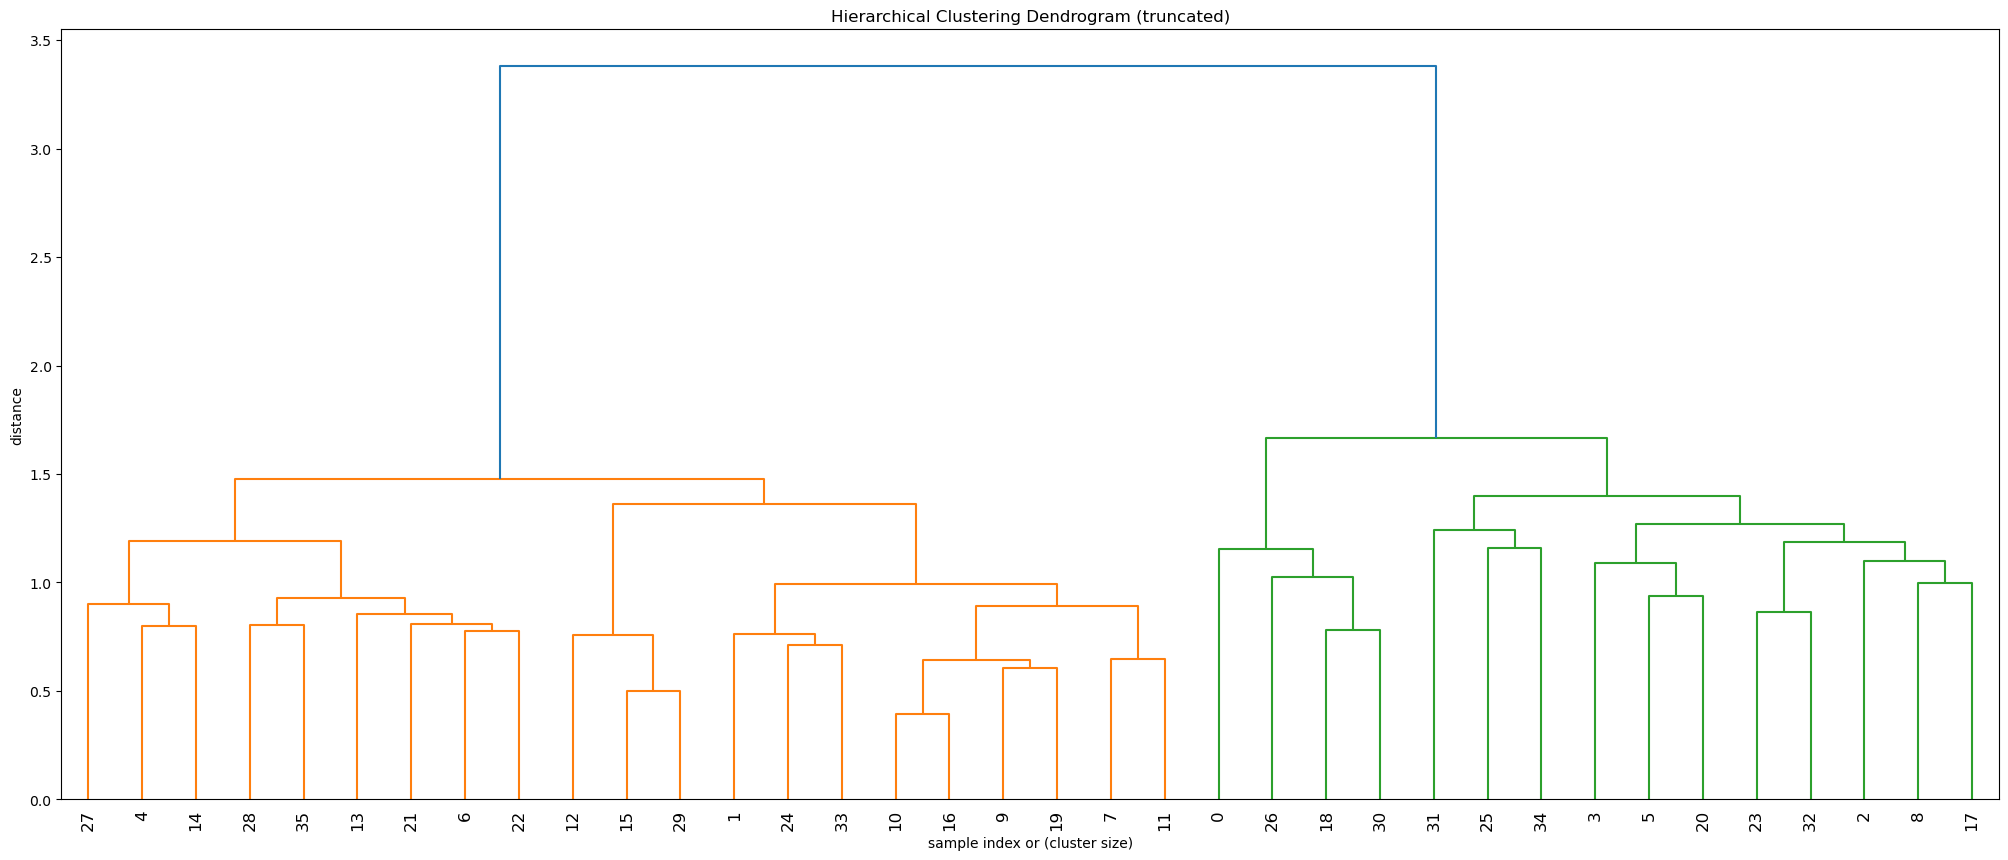

In [278]:
fig = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z_2008_dc,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

Comment:  
*We observe that the optimal number of clusters is two, and that the clusters are more-less equally sized.*

In [279]:
# Create the distance method using distance_correlation
fid = lambda column1, column2: fisher_clusters1(column1, column2) 
# Apply the distance method pairwise to every column
rslt_2008_fid = df_2008.apply(lambda col1: df_2008.apply(lambda col2: fid(col1, col2)))

In [280]:
Z_2008_fid = linkage(rslt_2008_fid, 'ward')
c, coph_dists = cophenet(Z_2008_fid, pdist(rslt_2008_fid))

/tmp/ipykernel_14856/2722520879.py:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



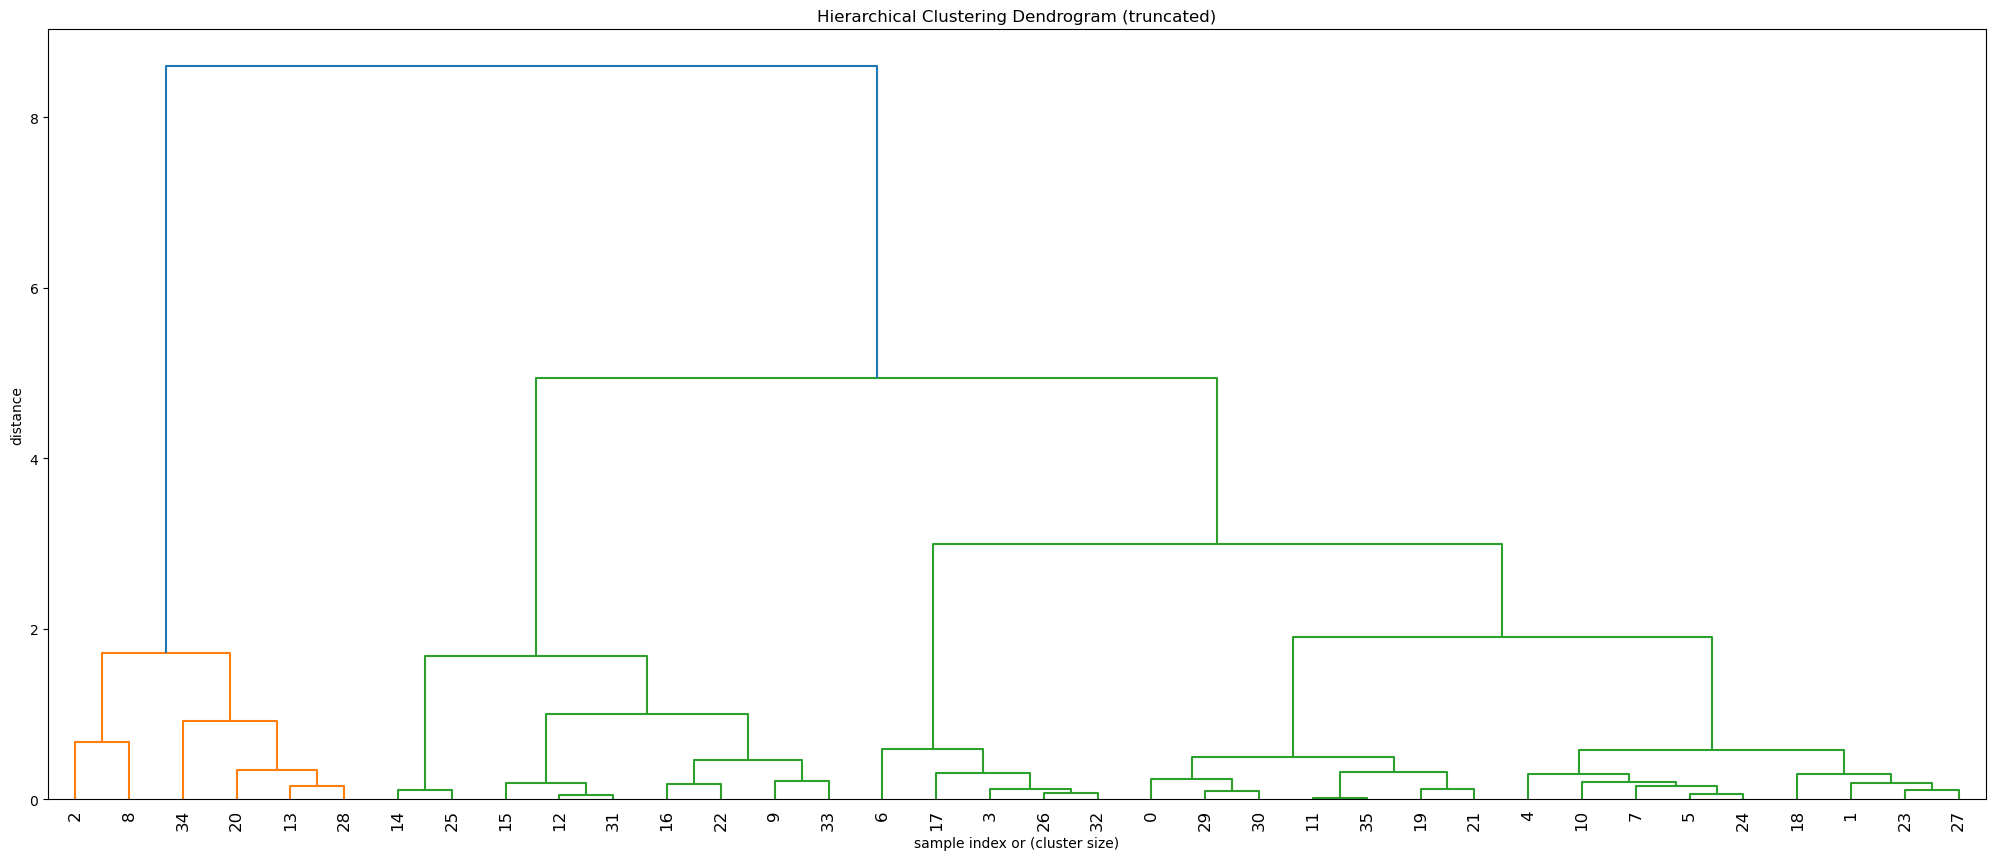

In [281]:
fig = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z_2008_fid,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

Comment:  
*In contrast, we have here two not eqally sized clusters.  
The bigger cluster consists primarily of the stocks from the Banking, Information/Communication, and Energy sectors, which are somewhat key drivers of the Thailands economy growth. The other smaller custer consists of stocks from the Services sector, which are probably more affected by the economic crisis.*

In [ ]:
df_2016=std_ret1[1958:2202]

In [ ]:
# Create the distance method using distance_correlation
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
# Apply the distance method pairwise to every column
rslt_2016_dc = df_2016.apply(lambda col1: df_2016.apply(lambda col2: distcorr(col1, col2)))

In [ ]:
Z_2016_dc = linkage(rslt_2016_dc, 'ward')
c, coph_dists = cophenet(Z_2016_dc, pdist(rslt_2016_dc))

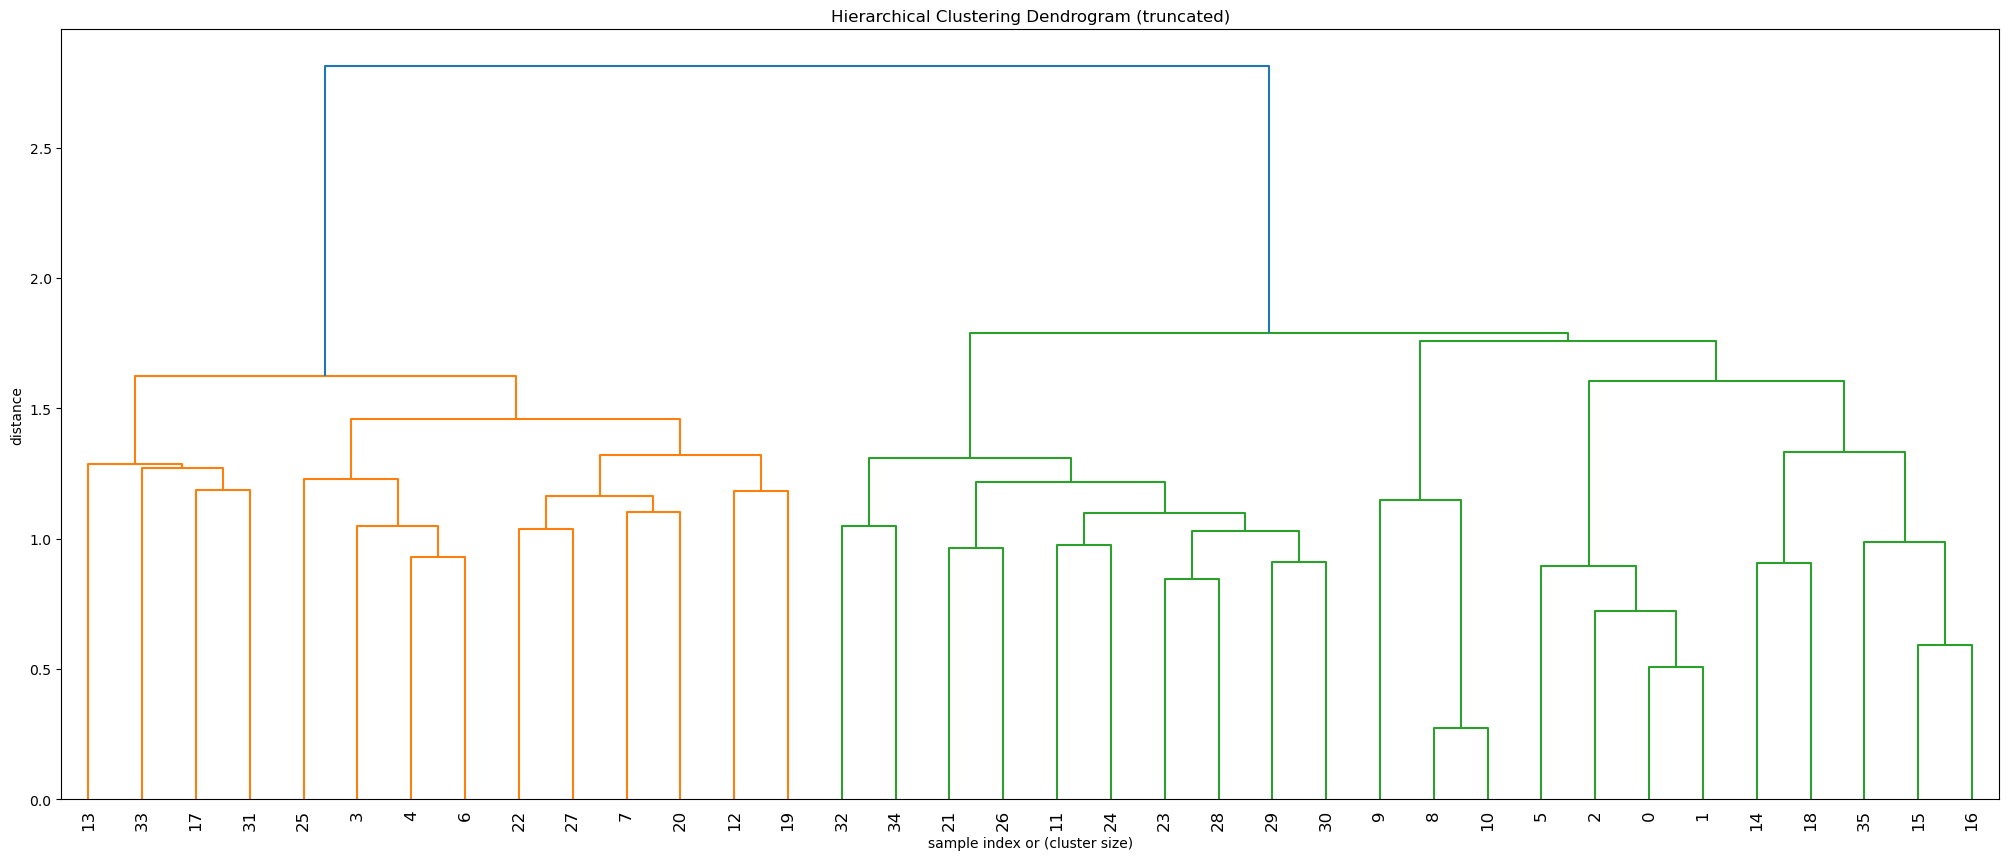

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z_2016_dc,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
# Apply the distance method pairwise to every column
rslt_2016_fid = df_2016.apply(lambda col1: df_2016.apply(lambda col2: fid(col1, col2)))

In [ ]:
Z_2016_fid = linkage(rslt_2016_fid, 'ward')
c, coph_dists = cophenet(Z_2016_fid, pdist(rslt_2016_fid))

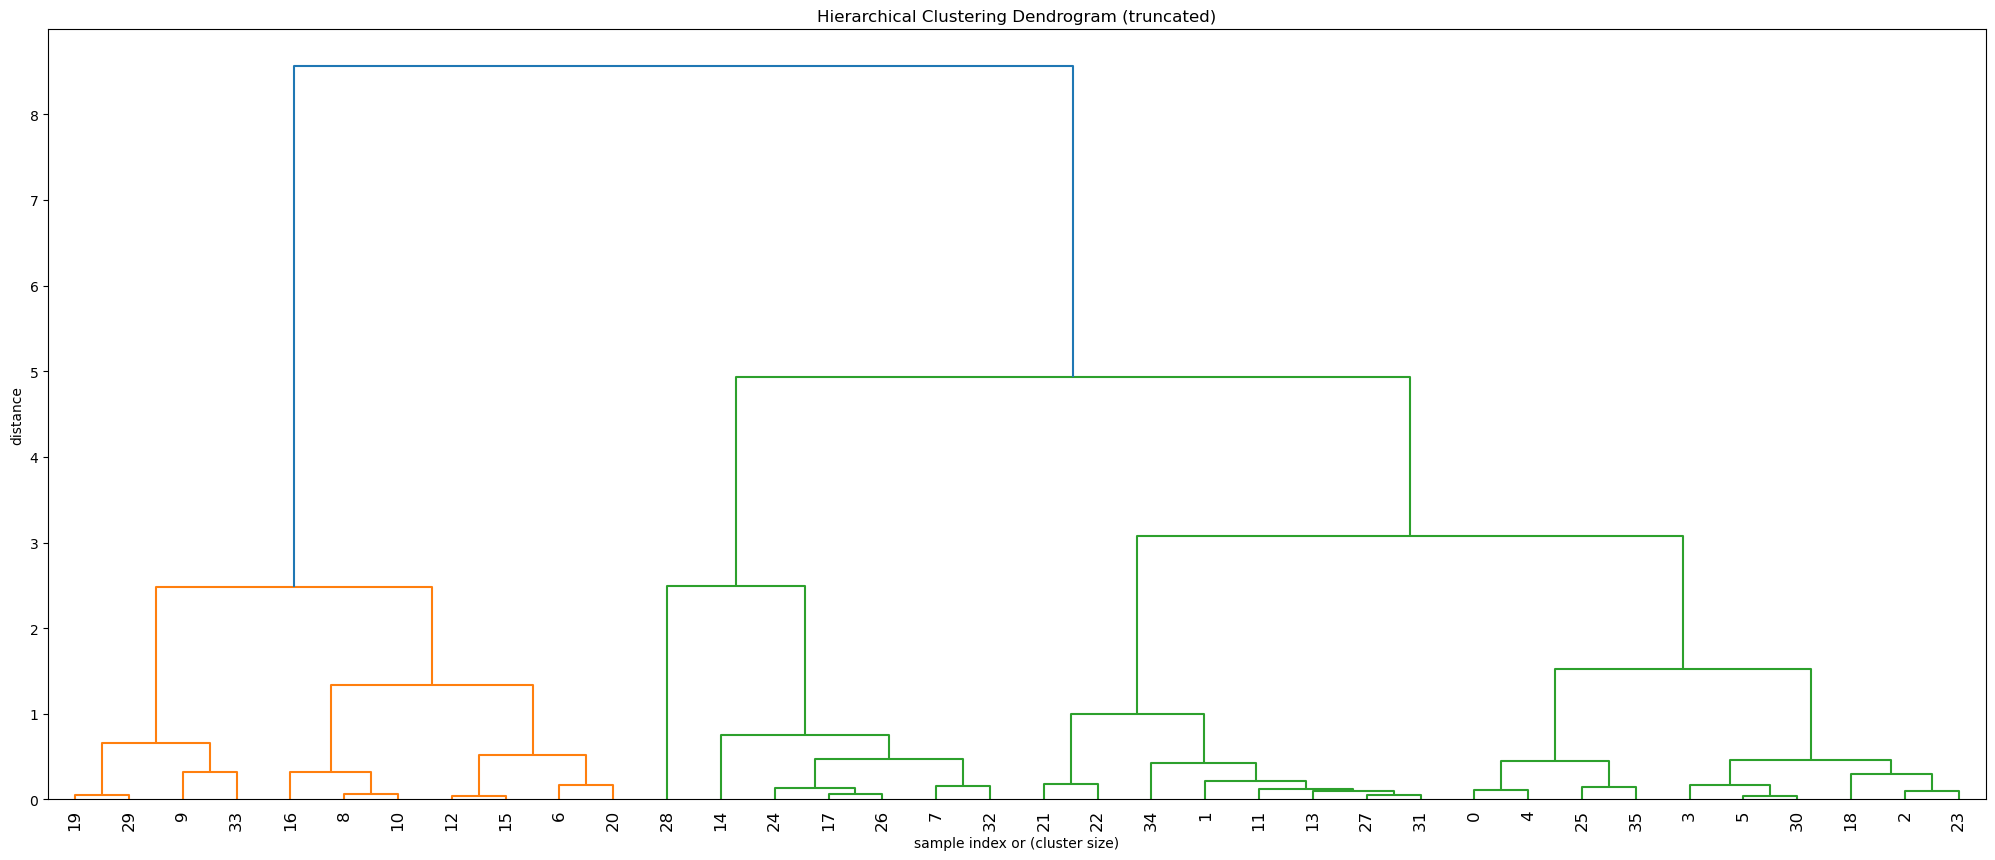

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z_2016_fid,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

Comment:  
*Interestingly both methods managed to group together stocks from the Telco sector, as in 2016 there was a 4G licences auction. We can consequently describe the two clusters presented here by, one having something to do with the 4G licences auction and the other belonging to  the "other" i.e., sectors whose business doesn't change much with the introduction of 4G technology.*

In [ ]:
df_2018=std_ret1[2444:2689]

In [ ]:
# Create the distance method using distance_correlation
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
# Apply the distance method pairwise to every column
rslt_2018_dc = df_2018.apply(lambda col1: df_2018.apply(lambda col2: distcorr(col1, col2)))

In [ ]:
Z_2018_dc = linkage(rslt_2018_dc, 'ward')
c, coph_dists = cophenet(Z_2018_dc, pdist(rslt_2018_dc))

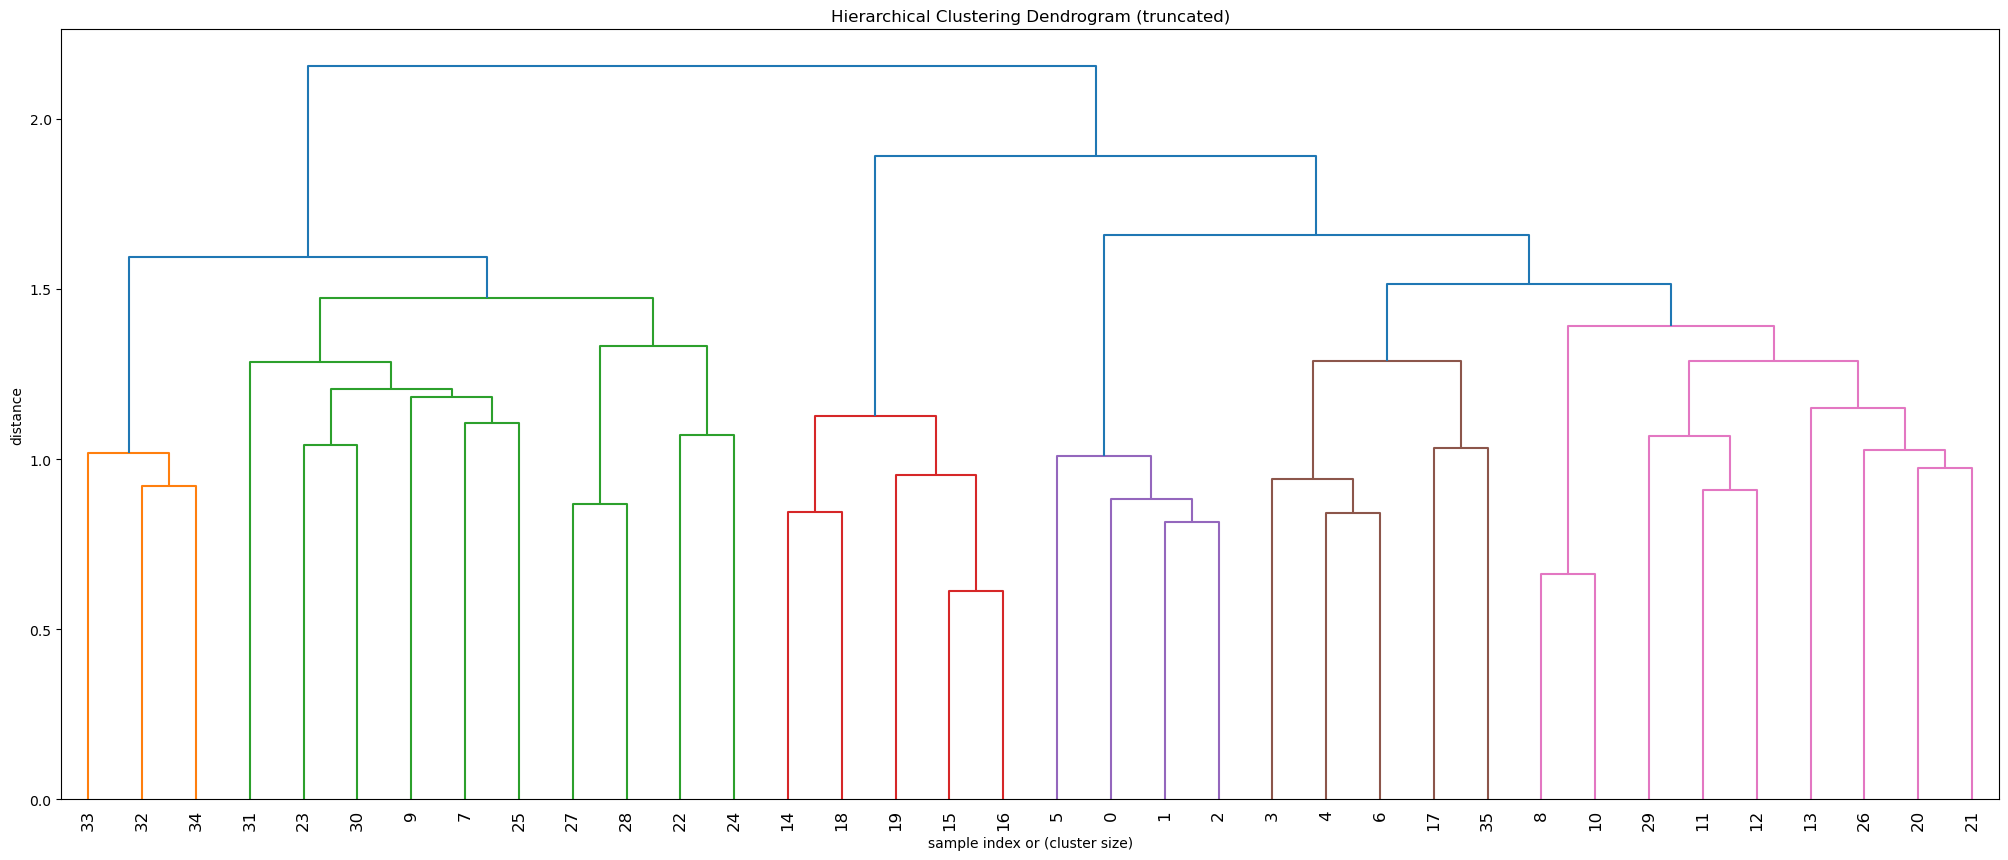

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z_2018_dc,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

Comment:  
*One cluster (right) has stocks from Banking, Energy, and Information and communication sector, the othe cluster have stocks from the Services sectors (Commerce, Transport,Healthcare...)*

In [ ]:
# Apply the distance method pairwise to every column
rslt_2018_fid = df_2016.apply(lambda col1: df_2018.apply(lambda col2: fid(col1, col2)))

In [ ]:
Z_2018_fid = linkage(rslt_2018_fid, 'ward')
c, coph_dists = cophenet(Z_2018_fid, pdist(rslt_2018_fid))


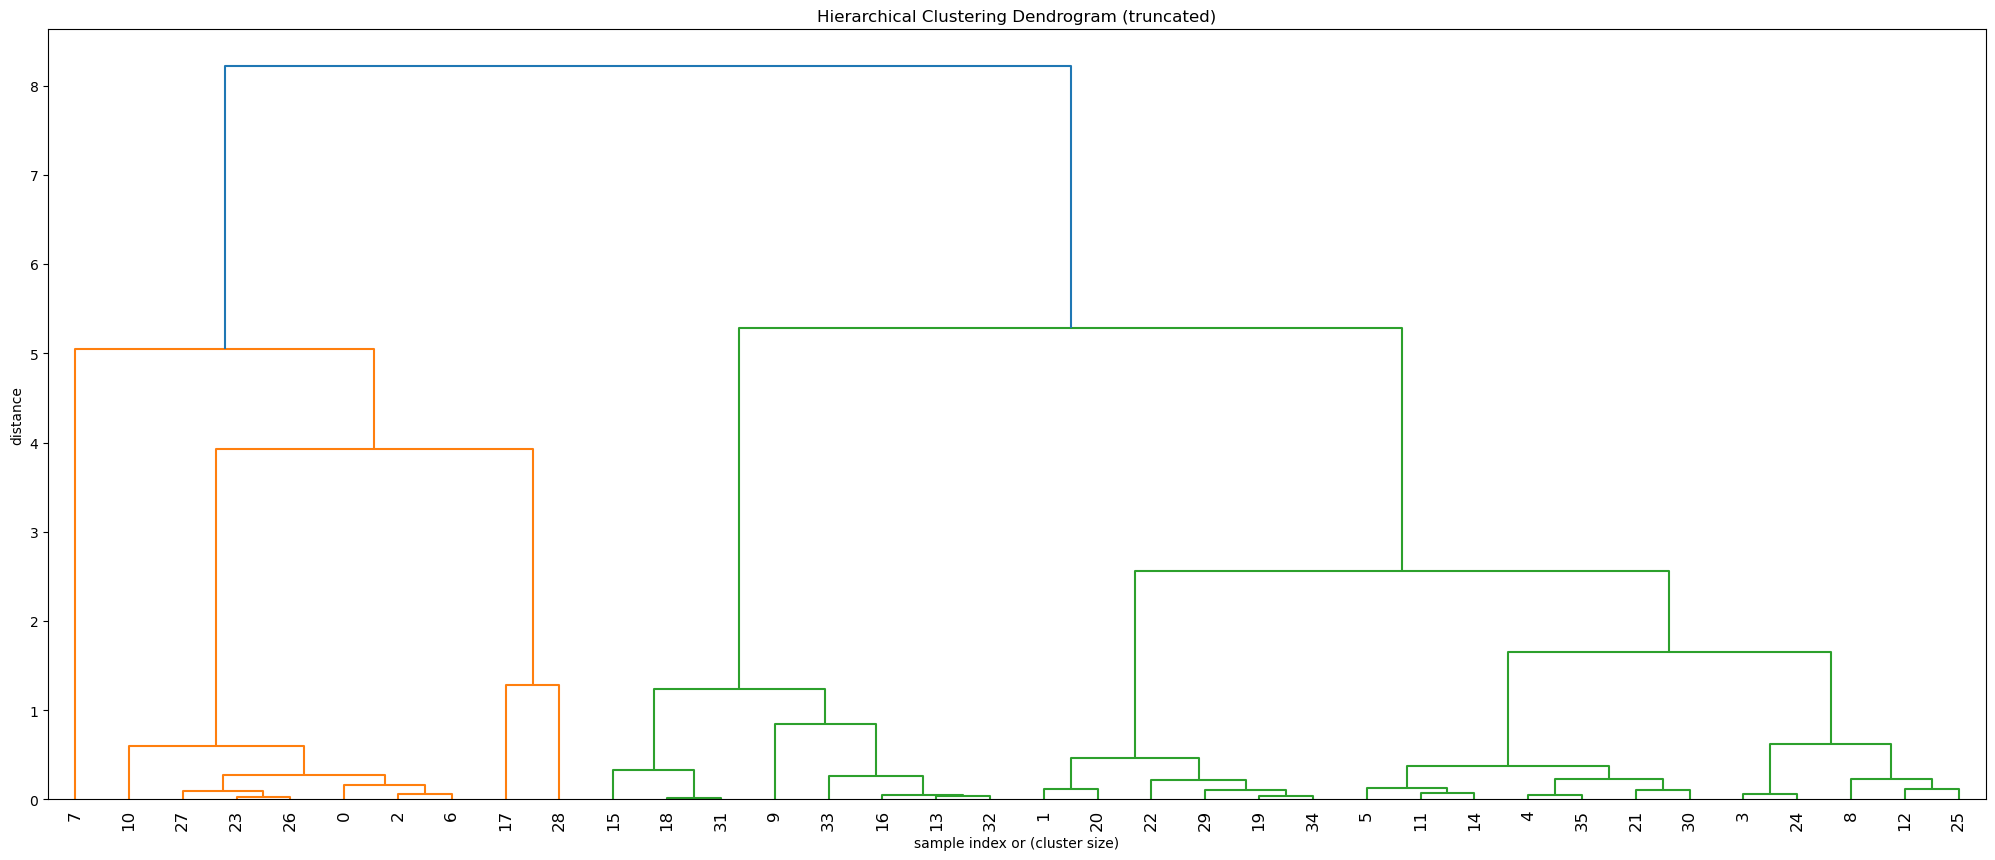

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z_2018_fid,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()